## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---

###  Computing Camera Matrix

In [2]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
%matplotlib inline

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        cv2.imshow('img',img)
        cv2.waitKey(500)

cv2.destroyAllWindows()

### Undistort Images

undistort uisng global variables
--- 0.01129603385925293 seconds ---
undistort from scratch
--- 0.777299165725708 seconds ---


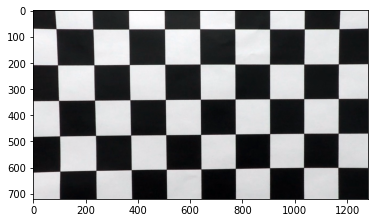

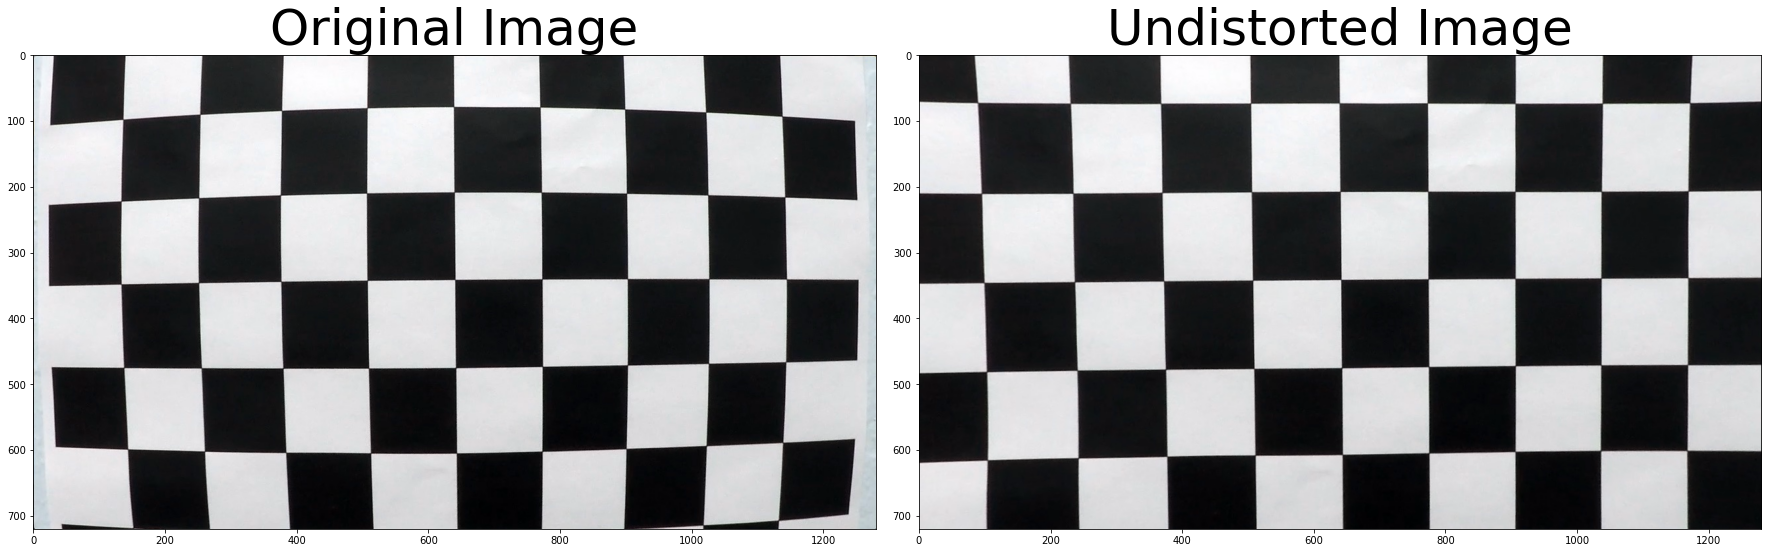

In [3]:
import time
# Read in an image
img = cv2.imread('camera_cal/calibration1.jpg')
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
shape = gray.shape[::-1]
# TODO: Save extracted matrix and use it for calibrating the camera
# this way the calculation of the distortion matrix needs to be done only 1 time

# this function extracts camera matrix
def cal_distortion_params(objpoints, imgpoints, shape):
    # camera calibration
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, shape, None, None)
    # return camera matrix
    # undist = cv2.undistort(img, mtx, dist, None, mtx)
    return mtx, dist
# Extract camera matrix
mtx, dist = cal_distortion_params(objpoints, imgpoints, shape)

# this function uses precalculated camera matrix 
def undistort_image(img):
    # use global variables
    global mtx, dist
    # calculate undistorted image
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist


print("undistort uisng global variables")
start_time = time.time()  # checking performance
image_undistorted = undistort_image(img)
print("--- %s seconds ---" % (time.time() - start_time))

plt.imshow(image_undistorted)

def cal_undistort(img, objpoints, imgpoints):
    # Use cv2.calibrateCamera() and cv2.undistort()
    # Transform image to gray scale
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    # camera calibration
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    # calculate undistorted image
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist

print("undistort from scratch")
start_time = time.time()  # checking performance
undistorted = cal_undistort(img, objpoints, imgpoints)
print("--- %s seconds ---" % (time.time() - start_time))
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undistorted)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Using Thresholding
Combining color and gradient thresholds for lane detection

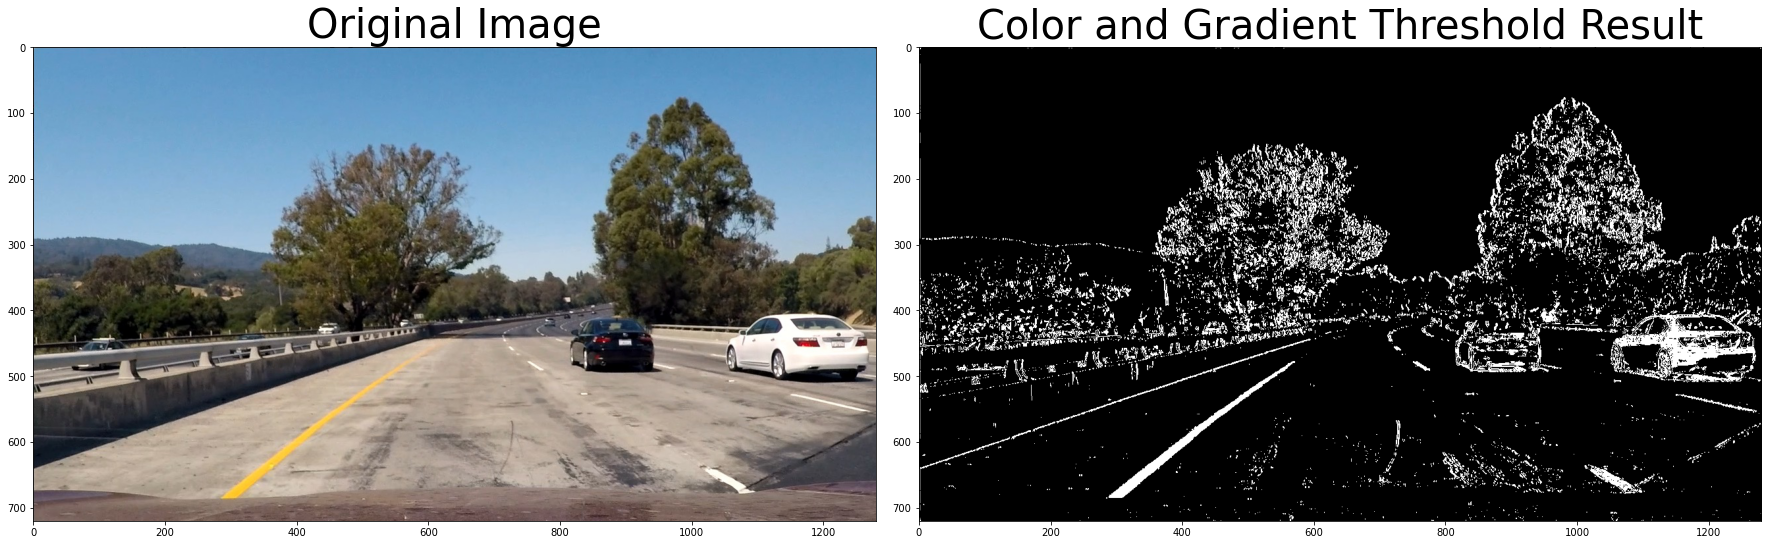

In [4]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline


image = mpimg.imread('test_images/test1.jpg')

# this pipeline detects lane lines using color and gradient thresholding.
def color_grad_threshold(img, s_thresh=(170, 255), sx_thresh=(20, 100)):
    img = np.copy(img)
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    # Sobel x
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    # Stack each channel
    # Note color_binary[:, :, 0] is all 0s, effectively an all black image. It might
    # be beneficial to replace this channel with something else.
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255
    
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1
    
    return combined_binary
    
threshold_image = color_grad_threshold(image)

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(image)
ax1.set_title('Original Image', fontsize=40)

ax2.imshow(threshold_image, cmap='gray')
ax2.set_title('Color and Gradient Threshold Result', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


## Perspective Transform 

In [10]:
%matplotlib qt

# color in RGB for drawing trapezoid
color = (255,0,0)  # red
# thickness
thickness = 2
# specify corners 
top_left = (573, 466)
top_right = (710, 466)
bottom_right = (1115, 720)
bottom_left = (205, 720)
# define 4 source points for the perspective transform
src = np.float32([list(top_left),list(top_right),list(bottom_left),list(bottom_right)])
#src = np.float32([[250,0],[950,0],[250,720],[950,720]])

# define 4 destination points for the perspective transform
dst = np.float32([[250,0],[995,0],[250,720],[995,720]])
# calculate transformation matrix
M_transformation = cv2.getPerspectiveTransform(src, dst)
Minv_transformation = cv2.getPerspectiveTransform(dst, src)
# image size needed for warping 
img_size = (img.shape[1], img.shape[0])

# function for perspective warping
def warp_perspective(image):
    global M_transformation, img_size
    warped = cv2.warpPerspective(image, M_transformation, img_size, flags=cv2.INTER_LINEAR)
    return warped

# Try for image with straight linesp
image = mpimg.imread('test_images/straight_lines1.jpg')
cv2.line(image, bottom_left, top_left, color, thickness)
cv2.line(image, top_left, top_right, color, thickness) 
cv2.line(image, top_right, bottom_right, color, thickness) 
cv2.line(image, bottom_right, bottom_left, color, thickness) 
warped = warp_perspective(image)

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(image)
ax1.set_title('Original Image', fontsize=40)

ax2.imshow(warped)
ax2.set_title('Warped Image', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

# Warp Threshold image
warped_image = warp_perspective(threshold_image)
#plt.imshow(warped_image, cmap='gray')

In [11]:
%matplotlib qt
image = mpimg.imread('test_images/straight_lines1.jpg')
plt.imshow(image)

## Detecting Lane Lines: 
using sliding window algorithm to detect line pixels

In [12]:
def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        ### TO-DO: Find the four below boundaries of the window ###
        win_xleft_low = leftx_current - margin  # TODO: if less then 0
        win_xleft_high = leftx_current + margin  # Update this
        win_xright_low = rightx_current - margin  # Update this
        win_xright_high = rightx_current + margin  # Update this
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        
        ### TO-DO: Identify the nonzero pixels in x and y within the window ###
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        ### TO-DO: If you found > minpix pixels, recenter next window ###
        ### (`right` or `leftx_current`) on their mean position ###
        
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img

# this function fits a ploynomial for the detected pixels
def fit_polynomial(binary_warped, xm_per_pix=30/720, ym_per_pix=3.7/720):
    '''
    Calculates lane line points and fits a second order polynomial 
    '''
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)

    # Fit a second order polynomial to each using `np.polyfit`
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Fit a second order plynomial using real measures
    left_fit_cr = np.polyfit(lefty  * ym_per_pix, leftx * xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty * ym_per_pix, rightx * xm_per_pix, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0] * ploty**2 + left_fit[1] * ploty + left_fit[2]
        right_fitx = right_fit[0] * ploty**2 + right_fit[1] * ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]
    # Plots the left and right polynomials on the lane lines
    #print(np.int32(left_fitx))
    #print(type(ploty))
    #plt.plot(left_fitx, ploty, color='yellow')
    #out_img[np.int32(ploty), np.int32(left_fitx)] = [0, 255, 255]
    #plt.plot(right_fitx, ploty, color='yellow')
    
    return out_img, ploty, left_fitx, right_fitx, left_fit_cr, right_fit_cr

# test on example image
out_img, ploty, left_fitx, right_fitx, left_fit_cr, right_fit_cr = fit_polynomial(warped_image)
plt.imshow(out_img)

## Measure Curvature 

In [13]:
def measure_curvature_real(ploty, left_fit_cr, right_fit_cr, xm_per_pix=3.7/700, ym_per_pix =30/720):
    '''
    Calculates the curvature of polynomial functions in meters.
    '''
    
    
    # Start by generating our fake example data
    # Make sure to feed in your real data instead in your project!
    
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty) * ym_per_pix

    
    ##### TO-DO: Implement the calculation of R_curve (radius of curvature) #####
    left_curverad = np.power(1 + np.square(2 * left_fit_cr[0] * y_eval + left_fit_cr[1]), 3/2) / np.abs( 2 * left_fit_cr[0])  ## Implement the calculation of the left line here
    right_curverad = np.power(1 + np.square(2 * right_fit_cr[0] * y_eval + right_fit_cr[1]), 3/2) / np.abs( 2 * right_fit_cr[0])  ## Implement the calculation of the right line here
    
    
    return left_curverad, right_curverad

# Pipeline

In [14]:
def pipeline(image):
    # distortion correction
    undsitorted_img= undistort_image(image)
    # color and gradient threshold
    threshold_image = color_grad_threshold(image)
    # Perspective transform
    warped_image = warp_perspective(threshold_image) 
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    # Detect Lane Lines: use sliding window algorithm
    out_img, ploty, left_fitx, right_fitx, left_fit_cr, right_fit_cr = fit_polynomial(warped_image)
    
    # Calculate curvature
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    left_curverad, right_curverad = measure_curvature_real(ploty, left_fit_cr, right_fit_cr, 
                                                           xm_per_pix=xm_per_pix, ym_per_pix=ym_per_pix)
    print(left_curverad, 'm', right_curverad, 'm')

    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped_image).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv_transformation, (image.shape[1], image.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undsitorted_img, 1, newwarp, 0.3, 0)
    return result


# test image
image = mpimg.imread('test_images/test5.jpg')
# aply lane line detection
result = pipeline(image)
# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(image)
ax1.set_title('Original Image', fontsize=40)

ax2.imshow(result)
ax2.set_title('Pipeline Output', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

2914.0796984156195 m 8829.80174228194 m


## Test Pipeline for video

In [21]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML


white_output = 'output_videos/challenge_video.mp4' # harder_challenge_video.mp4' #
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("challenge_video.mp4").subclip(0,5) #("harder_challenge_video.mp4").subclip(5,10) #
white_clip = clip1.fl_image(pipeline) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False,)

t:   0%|          | 0/150 [00:00<?, ?it/s, now=None]

3791.34643421745 m 20489.75839305862 m
Moviepy - Building video output_videos/challenge_video.mp4.
Moviepy - Writing video output_videos/challenge_video.mp4

3791.34643421745 m 20489.75839305862 m


t:   2%|▏         | 3/150 [00:00<00:14, 10.13it/s, now=None]

7941.5785542858275 m 26673.810144809766 m
11616.050025548548 m 32547.512000587725 m


t:   3%|▎         | 5/150 [00:00<00:22,  6.54it/s, now=None]

19621.82260934128 m 33550.69622674902 m


t:   4%|▍         | 6/150 [00:00<00:24,  5.89it/s, now=None]

7443.579766261499 m 37418.49172202123 m


t:   5%|▍         | 7/150 [00:01<00:25,  5.54it/s, now=None]

23265.752375338026 m 37557.196273492154 m
92077.56588094367 m 45767.361065002726 m


t:   6%|▌         | 9/150 [00:01<00:25,  5.56it/s, now=None]

27554.880221466963 m 38254.75600423065 m


t:   7%|▋         | 11/150 [00:01<00:24,  5.78it/s, now=None]

45277.220486040795 m 29230.529144403 m
62607.86801316755 m 31641.47754607654 m


t:   9%|▊         | 13/150 [00:02<00:19,  7.07it/s, now=None]

4238.890169920343 m 28954.600729627477 m
5413.098225596889 m 37407.35273039472 m


t:  10%|█         | 15/150 [00:02<00:17,  7.69it/s, now=None]

22465.721505480535 m 28570.30060996176 m
1557.7118299998838 m 27353.97080146736 m


t:  11%|█▏        | 17/150 [00:02<00:18,  7.33it/s, now=None]

11456.17050999725 m 18578.281284189252 m
8708.922952684798 m 15638.382713068451 m


t:  13%|█▎        | 19/150 [00:02<00:19,  6.72it/s, now=None]

15741.159787002836 m 15566.100135691426 m
49896.15329112257 m 30204.705265194687 m


t:  14%|█▍        | 21/150 [00:03<00:17,  7.37it/s, now=None]

85157.11297843192 m 37305.58182565953 m
113146.41050008302 m 55320.186963372376 m


t:  15%|█▌        | 23/150 [00:03<00:17,  7.20it/s, now=None]

87909.44699349208 m 89742.09871500228 m
9241.887725328765 m 43920.8364073822 m


t:  17%|█▋        | 25/150 [00:03<00:18,  6.82it/s, now=None]

125874.72977504844 m 36292.792475064845 m
176680.968204486 m 82896.03705850962 m


t:  18%|█▊        | 27/150 [00:04<00:18,  6.59it/s, now=None]

193443.62892338363 m 96520.41491835819 m
120769.03638996289 m 104233.11356653245 m


t:  19%|█▉        | 29/150 [00:04<00:18,  6.39it/s, now=None]

167167.07493583875 m 93256.92939690856 m
126560.06169805097 m 51321.89796839288 m


t:  21%|██        | 31/150 [00:04<00:17,  6.84it/s, now=None]

138590.54376593896 m 75401.69722716787 m
177424.86694251565 m 50626.493139774044 m


t:  21%|██▏       | 32/150 [00:04<00:17,  6.58it/s, now=None]

133773.25097754347 m 56116.885097005965 m


t:  23%|██▎       | 34/150 [00:05<00:19,  5.87it/s, now=None]

55976.164713915154 m 62195.38865407264 m
22253.901998929596 m 56636.027902301044 m


t:  24%|██▍       | 36/150 [00:05<00:17,  6.45it/s, now=None]

58382.40577892384 m 46493.53336966018 m
60739.605075533815 m 44360.36831220416 m


t:  25%|██▍       | 37/150 [00:05<00:17,  6.47it/s, now=None]

123587.16236699988 m 61272.613156715626 m
140728.4384381339 m 71920.70299069374 m


t:  27%|██▋       | 40/150 [00:06<00:17,  6.16it/s, now=None]

112289.50461568295 m 51419.71619007967 m
94082.40685576362 m 37514.75510491639 m


t:  28%|██▊       | 42/150 [00:06<00:15,  7.12it/s, now=None]

211251.1130772262 m 35900.65364052833 m
188721.04575080864 m 26251.742812966426 m


t:  29%|██▉       | 44/150 [00:06<00:14,  7.30it/s, now=None]

501528.138998931 m 21422.44347062665 m
524902.3251512772 m 28026.321131039615 m


t:  31%|███       | 46/150 [00:06<00:14,  6.96it/s, now=None]

550003.3222886504 m 101134.29745185743 m
488175.69694784435 m 104360.8653407117 m


t:  32%|███▏      | 48/150 [00:07<00:13,  7.80it/s, now=None]

496308.47333488514 m 78846.58373438535 m
476353.67884005496 m 31192.68941866833 m


t:  33%|███▎      | 50/150 [00:07<00:12,  7.98it/s, now=None]

5047.776423727573 m 25865.4300651292 m
386797.5632189539 m 35895.65706140304 m


t:  35%|███▍      | 52/150 [00:07<00:11,  8.31it/s, now=None]

458157.66838559817 m 38489.744789366276 m
402611.8889913627 m 39441.29440976413 m


t:  36%|███▌      | 54/150 [00:07<00:12,  7.66it/s, now=None]

374019.16556387587 m 39353.776701231654 m
304547.0749258141 m 38614.11971478367 m


t:  37%|███▋      | 56/150 [00:08<00:12,  7.27it/s, now=None]

255656.592030509 m 35884.5026775495 m
193782.4043362411 m 32916.406327608915 m


t:  38%|███▊      | 57/150 [00:08<00:12,  7.16it/s, now=None]

207960.93946034808 m 34808.2214783171 m
213430.79875793273 m 38871.73651521421 m


t:  40%|████      | 60/150 [00:08<00:13,  6.64it/s, now=None]

201642.8368956904 m 93856.52681729142 m
154437.24974897585 m 84348.94968932783 m


t:  41%|████▏     | 62/150 [00:09<00:13,  6.50it/s, now=None]

187154.9862930516 m 80550.36519266697 m
181861.50067580334 m 18578.100947414456 m


t:  43%|████▎     | 64/150 [00:09<00:13,  6.41it/s, now=None]

190202.65169954894 m 19374.36247816514 m
164513.96469511386 m 21882.028318270233 m


t:  44%|████▍     | 66/150 [00:09<00:13,  6.11it/s, now=None]

148254.47061166546 m 33559.56662646694 m
124686.1355978586 m 27495.346909614498 m


t:  45%|████▍     | 67/150 [00:10<00:13,  5.98it/s, now=None]

80049.32997775129 m 36931.617665080244 m
61477.08100189603 m 38182.82630142089 m


t:  47%|████▋     | 70/150 [00:10<00:13,  5.99it/s, now=None]

33389.63655134752 m 24768.309956184163 m
124711.40489574519 m 16244.597919694896 m


t:  48%|████▊     | 72/150 [00:10<00:12,  6.16it/s, now=None]

40722.048393852914 m 25980.39599379021 m
35319.8876525947 m 8087.708826896861 m


t:  49%|████▊     | 73/150 [00:11<00:13,  5.81it/s, now=None]

28604.38287056902 m 18559.063268765338 m
24015.0205229248 m 4767.607610171983 m


t:  51%|█████     | 76/150 [00:11<00:12,  5.86it/s, now=None]

32032.991520786683 m 16740.650341542696 m
50196.01080266787 m 22761.77878548719 m


t:  52%|█████▏    | 78/150 [00:11<00:12,  5.64it/s, now=None]

46664.68740022689 m 20218.556068091824 m
37702.205702241095 m 14846.513950489098 m


t:  53%|█████▎    | 80/150 [00:12<00:12,  5.70it/s, now=None]

25159.81228315585 m 18676.023137023163 m
23454.462521114394 m 16146.823637852176 m


t:  54%|█████▍    | 81/150 [00:12<00:13,  5.21it/s, now=None]

19651.111916172995 m 14732.125800705626 m
12808.036351887065 m 20558.86875470613 m


t:  55%|█████▌    | 83/150 [00:12<00:13,  5.04it/s, now=None]

12454.00876293362 m 16271.316560071255 m
5197.488841306528 m 12408.485912804064 m


t:  57%|█████▋    | 85/150 [00:13<00:12,  5.40it/s, now=None]

6191.073996167173 m 33150.35423698731 m
6969.368412810665 m 52028.6641183729 m


t:  59%|█████▊    | 88/150 [00:13<00:11,  5.56it/s, now=None]

13290.521928210312 m 89284.27528421862 m
14058.885723375632 m 24415.864516674443 m


t:  60%|██████    | 90/150 [00:14<00:11,  5.42it/s, now=None]

10740.180840212386 m 377033.313815205 m
25266.030687145187 m 65016.095531849016 m


t:  61%|██████▏   | 92/150 [00:14<00:09,  6.25it/s, now=None]

21183.87820541998 m 48982.55230740963 m
32928.34447982827 m 19672.949466709553 m


t:  62%|██████▏   | 93/150 [00:14<00:08,  6.42it/s, now=None]

18301.96648772741 m 9195.462496137114 m
22253.565947467712 m 1214.5307646789765 m


t:  64%|██████▍   | 96/150 [00:15<00:08,  6.02it/s, now=None]

26288.894631282594 m 1450.3676770770428 m
32197.173929976747 m 29646.56705148602 m


t:  65%|██████▌   | 98/150 [00:15<00:08,  6.19it/s, now=None]

59617.630057130074 m 32199.017992247278 m
93589.15079921923 m 37708.122570594205 m


t:  66%|██████▌   | 99/150 [00:15<00:09,  5.37it/s, now=None]

104866.82042988451 m 38054.887367421885 m


t:  67%|██████▋   | 101/150 [00:16<00:09,  5.44it/s, now=None]

156347.14981768237 m 43038.976337929846 m
138617.04600447053 m 36767.756873907056 m


t:  69%|██████▊   | 103/150 [00:16<00:08,  5.75it/s, now=None]

123060.5598238454 m 31773.72224973835 m
187139.77631847962 m 26413.868681588065 m


t:  70%|███████   | 105/150 [00:16<00:07,  5.86it/s, now=None]

214316.81618745404 m 27260.849067807845 m
187942.50997587657 m 26698.377196496713 m


t:  71%|███████▏  | 107/150 [00:17<00:07,  5.84it/s, now=None]

188028.5025944821 m 41625.77575809041 m
178234.31980794636 m 46557.089559613145 m


t:  73%|███████▎  | 109/150 [00:17<00:06,  6.30it/s, now=None]

186396.9842464551 m 47999.53481675853 m
265215.7401114901 m 25766.518918767484 m


t:  73%|███████▎  | 110/150 [00:17<00:06,  6.33it/s, now=None]

426009.05287767836 m 26356.403436600558 m
486881.3504274003 m 79268.90443364347 m


t:  75%|███████▌  | 113/150 [00:18<00:05,  6.35it/s, now=None]

649343.022283517 m 92722.7748999667 m
834801.2117743231 m 100474.7679444683 m


t:  76%|███████▌  | 114/150 [00:18<00:06,  5.94it/s, now=None]

840109.1207671313 m 82757.43692703702 m


t:  77%|███████▋  | 115/150 [00:18<00:06,  5.30it/s, now=None]

805051.2143088643 m 68704.0189623173 m


t:  77%|███████▋  | 116/150 [00:18<00:06,  5.04it/s, now=None]

892502.9187522572 m 45738.338451606105 m


t:  79%|███████▊  | 118/150 [00:19<00:06,  5.16it/s, now=None]

965672.7811280185 m 49873.316625738735 m
1722174.1881330975 m 44786.65661350159 m


t:  80%|████████  | 120/150 [00:19<00:05,  5.87it/s, now=None]

1640476.3053614798 m 64009.85832309176 m
1812098.2750742582 m 155040.36850327384 m


t:  82%|████████▏ | 123/150 [00:19<00:03,  7.55it/s, now=None]

1860337.9785591366 m 953599.9458264085 m
1412360.183812492 m 22755.36387186793 m
8873.733224480891 m 8098.737823817506 m


t:  83%|████████▎ | 125/150 [00:19<00:02,  8.41it/s, now=None]

1178431.4210499574 m 14017.838695930619 m
1441489.8609606288 m 18683.877315704656 m
10016.072217950687 m 31674.427999648233 m


t:  86%|████████▌ | 129/150 [00:20<00:02,  9.89it/s, now=None]

184977.96079278897 m 56861.30419661175 m
551640.3486563497 m 44382.044035202875 m
2165636.964207842 m 51826.4701765474 m


t:  87%|████████▋ | 131/150 [00:20<00:01, 10.44it/s, now=None]

4187.127809805169 m 28003.799384746086 m
4079.657632193772 m 10912.93165265384 m
3556.876736316314 m 32092.557162328194 m


t:  90%|█████████ | 135/150 [00:20<00:01, 11.28it/s, now=None]

2344.5051445462245 m 38609.91237089237 m
2417653086.428473 m 5251.942613491312 m
30154816.80903995 m 11304.305623709468 m


t:  91%|█████████▏| 137/150 [00:20<00:01, 10.60it/s, now=None]

106499215.19253816 m 49502.664918558294 m
8706.333512685793 m 28325.226599545345 m


t:  93%|█████████▎| 139/150 [00:21<00:01,  9.58it/s, now=None]

474073449.4059556 m 17764.991564342206 m
8863896.23145618 m 8167.838071932632 m


t:  94%|█████████▍| 141/150 [00:21<00:01,  8.46it/s, now=None]

41621113.68641608 m 7400.59101600946 m
2278466242.9889193 m 13312.33842642855 m


t:  95%|█████████▌| 143/150 [00:21<00:00,  7.82it/s, now=None]

497397172.59395885 m 14001.926426856831 m
194519.9757861977 m 76161.11813060366 m


t:  97%|█████████▋| 145/150 [00:21<00:00,  7.42it/s, now=None]

187237.2495882534 m 61034.990392612555 m
90671.35184624819 m 82794.54089040574 m


t:  97%|█████████▋| 146/150 [00:22<00:00,  7.96it/s, now=None]

120740.27178122094 m 62585.69479642867 m
57370.307386869805 m 45827.82212160911 m


t:  99%|█████████▉| 149/150 [00:22<00:00,  7.59it/s, now=None]

7778.1639929511075 m 23518.430312854547 m
47.37096521330403 m 15895.899356299067 m


157.31913244514323 m 16181.910253077214 m
9758.138995267578 m 16810.62145266671 m


Moviepy - Done !
Moviepy - video ready output_videos/challenge_video.mp4
CPU times: user 2min 24s, sys: 4.78 s, total: 2min 28s
Wall time: 23.9 s


In [20]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

In [22]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None 
# define 2 instances for left and right line
left_line

NameError: name 'left_line' is not defined